# RNNs for Time-series
## Contents
1. Feature engineering for TS
1. Error analysis methods
2. Helper functions for future examples
3. Example 1: Bitcoin Prediction
4. Example 2: Bike Sharing Prediction
5. Example 3: Real Estate Prediction
## Reference
- https://github.com/thekimk/All-About-Time-Series-Analysis/
- https://towardsdatascience.com/time-series-diy-seasonal-decomposition-f0b469afed44

## Import libraries

In [38]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation, visualization and useful functions
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40
import numpy as np
from itertools import product # iterative combinations
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling algorithms
# General(Statistics/Econometrics)
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error
# for classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## 1. Feature engineering for TS
1. Data shapes
1. Seasonal analysis
1. Manually extract time features

### 1.Data shapes

            BTC-USD
Date               
2017-01-01   998.33
2017-01-02 1,021.75
2017-01-03 1,043.84
2017-01-04 1,154.73
2017-01-05 1,013.38


<AxesSubplot:xlabel='Date'>

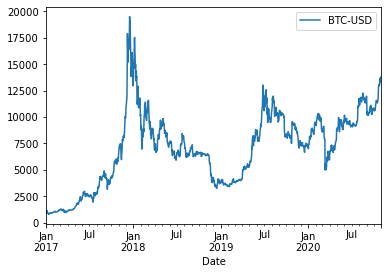

In [39]:
# Bitcoin
bitcoin_location = 'https://raw.githubusercontent.com/thekimk/All-About-Time-Series-Analysis/c0dcc1b31932dc569c3908715c83533f1b6bdb2c/Data/Cryptocurrency/Bitcoin.csv'
bitcoin_all = pd.read_csv(bitcoin_location, index_col='Date')
bitcoin_all.index = pd.to_datetime(bitcoin_all.index)
print(bitcoin_all.head())
bitcoin_all.plot()

In [40]:
# Bike sharing
bike_location = 'https://raw.githubusercontent.com/thekimk/All-About-Time-Series-Analysis/c0dcc1b31932dc569c3908715c83533f1b6bdb2c/Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv'
bike_all = pd.read_csv(bike_location)
bike_all.head(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 0:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16
1,2011-01-01 1:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40
2,2011-01-01 2:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32
3,2011-01-01 3:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13
4,2011-01-01 4:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1
5,2011-01-01 5:00,1,0,0,2,9.84,12.88,75,6.00,0,1,1
6,2011-01-01 6:00,1,0,0,1,9.02,13.63,80,0.00,2,0,2
7,2011-01-01 7:00,1,0,0,1,8.20,12.88,86,0.00,1,2,3
8,2011-01-01 8:00,1,0,0,1,9.84,14.39,75,0.00,1,7,8
9,2011-01-01 9:00,1,0,0,1,13.12,17.43,76,0.00,8,6,14


In [41]:
# Real estiate (Gangnam)
re_location = 'https://raw.githubusercontent.com/thekimk/All-About-Time-Series-Analysis/c0dcc1b31932dc569c3908715c83533f1b6bdb2c/Data/RealestateKorea_Gangnam/Economy.csv'
re_all = pd.read_csv(re_location)
re_all.head(10)

,Price,Date,Region,Price_Sido,Year,Month,Building_Type,Construction_Amount,CD_Rate,Deposit_Rate,Exchange_Rate,Composite_Stock_Price,Economy_Growth,Exchequer_Bond_3Y,Household_Loan_All,Mortgage_All,Number_Of_Nosells,Unsalenum
0,69.50,2006-01-01,48000,69.40,2006,1,0,"4,867,793.00",4.15,4.06,971.00,"1,379.32",1.80,5.02,NaN,NaN,NaN,NaN
1,64.60,2006-01-01,48000,64.50,2006,1,1,"4,867,793.00",4.15,4.06,971.00,"1,379.32",1.80,5.02,NaN,NaN,NaN,NaN
2,69.70,2006-01-01,47000,69.30,2006,1,1,"4,867,793.00",4.15,4.06,971.00,"1,379.32",1.80,5.02,NaN,NaN,NaN,NaN
3,94.20,2006-01-01,45000,94.20,2006,1,7,"4,867,793.00",4.15,4.06,971.00,"1,379.32",1.80,5.02,NaN,NaN,NaN,NaN
4,80.00,2006-01-01,48000,80.00,2006,1,7,"4,867,793.00",4.15,4.06,971.00,"1,379.32",1.80,5.02,NaN,NaN,NaN,NaN
5,82.90,2006-01-01,42000,82.90,2006,1,3,"4,867,793.00",4.15,4.06,971.00,"1,379.32",1.80,5.02,NaN,NaN,NaN,NaN
6,62.10,2006-01-01,28000,62.00,2006,1,0,"4,867,793.00",4.15,4.06,971.00,"1,379.32",1.80,5.02,NaN,NaN,NaN,NaN
7,94.60,2006-01-01,46000,94.40,2006,1,7,"4,867,793.00",4.15,4.06,971.00,"1,379.32",1.80,5.02,NaN,NaN,NaN,NaN
8,65.30,2006-01-01,28000,65.20,2006,1,1,"4,867,793.00",4.15,4.06,971.00,"1,379.32",1.80,5.02,NaN,NaN,NaN,NaN
9,67.60,2006-01-01,26000,67.50,2006,1,0,"4,867,793.00",4.15,4.06,971.00,"1,379.32",1.80,5.02,NaN,NaN,NaN,NaN


### 2.Seasonal decomposition with `seasonal_decompose` from `statsmodel`
It splits a time series into three components: trend, seasonality, and the residuals. 
* trend — the general direction of the series over a long period of time
* seasonality — a distinct, repeating pattern observed in regular intervals due to various seasonal factors. Could be monthly, weekly, etc.
* residual — the irregular component consisting of the fluctuations in the time series after removing the previous components

<AxesSubplot:title={'center':'Airline passengers'}, xlabel='Month'>

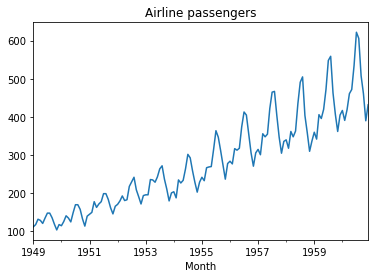

In [42]:
airline_location = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
dt = pd.read_csv(airline_location, index_col=0)
dt.index = pd.to_datetime(dt.index)
y = dt["Passengers"]
y.name = "n_passengers"

y.plot(title="Airline passengers")

Benchmark from statsmodels

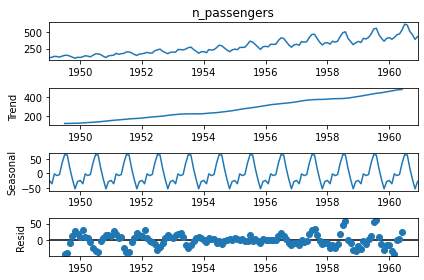

In [43]:
airline_seasonal_decomp = sm.tsa.seasonal_decompose(y, model='additive')
airline_seasonal_decomp.plot();


Manual decomposition

In [44]:
# create the dt
seasonal_dt = y.to_frame()

# calculate the trend component
seasonal_dt["trend"] = seasonal_dt["n_passengers"].rolling(window=13, center=True).mean()

# detrend the series
seasonal_dt["detrended"] = seasonal_dt["n_passengers"] - seasonal_dt["trend"]

# calculate the seasonal component
seasonal_dt.index = pd.to_datetime(seasonal_dt.index)
seasonal_dt["month"] = seasonal_dt.index.month
seasonal_dt["seasonality"] = seasonal_dt.groupby("month")["detrended"].transform("mean")

# get the residuals
seasonal_dt["resid"] = seasonal_dt["detrended"] - seasonal_dt["seasonality"]

# display the dt
seasonal_dt.head(15)

,n_passengers,trend,detrended,month,seasonality,resid
Month,,,,,,
1949-01-01,112,NaN,NaN,1,-30.83,NaN
1949-02-01,118,NaN,NaN,2,-42.03,NaN
1949-03-01,132,NaN,NaN,3,-4.14,NaN
1949-04-01,129,NaN,NaN,4,-6.94,NaN
1949-05-01,121,NaN,NaN,5,-0.70,NaN
1949-06-01,135,NaN,NaN,6,37.15,NaN
1949-07-01,148,125.77,22.23,7,64.92,-42.69
1949-08-01,148,126.85,21.15,8,64.58,-43.43
1949-09-01,136,128.62,7.38,9,15.64,-8.25


Plot results

array([<AxesSubplot:xlabel='Month'>, <AxesSubplot:xlabel='Month'>,
       <AxesSubplot:xlabel='Month'>, <AxesSubplot:xlabel='Month'>],
      dtype=object)

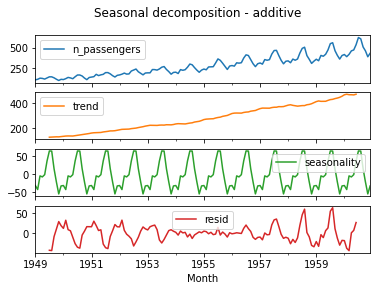

In [45]:
(
    seasonal_dt
    .loc[:, ["n_passengers", "trend", "seasonality", "resid"]]
    .plot(subplots=True, title="Seasonal decomposition - additive")
)


Results comparison (`manual vs seasonal_decompose`)

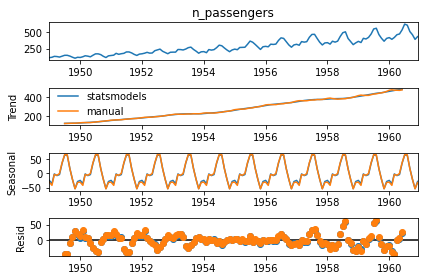

In [46]:

from statsmodels.tsa.seasonal import DecomposeResult


manual_decomposition = DecomposeResult(
    seasonal=seasonal_dt["seasonality"],
    trend=seasonal_dt["trend"],
    resid=seasonal_dt["resid"],
    observed=seasonal_dt["n_passengers"],
)


def add_second_decomp_plot(fig, res, legend):
    axs = fig.get_axes()
    comps = ["trend", "seasonal", "resid"]
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == "resid":
            ax.plot(series, marker="o", linestyle="none")
        else:
            ax.plot(series)
            if comp == "trend":
                ax.legend(legend, frameon=False)


fig = airline_seasonal_decomp.plot()
add_second_decomp_plot(fig, manual_decomposition, ["statsmodels", "manual"])


Conclusion
* the basic approach to seasonal decomposition splits the time series into three components: trend, seasonal and residuals,
* the trend component is calculated as a centered moving average of the original series,
* the seasonal component is calculated as the per period average of the detrended series,
* the residual component is obtained after removing the trend and seasonal components from the time series.

### 3. Manually extract time features
How to turn `datetime` to day, week, month, quarter, ...

In [47]:
bike_all.head()


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 0:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16
1,2011-01-01 1:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40
2,2011-01-01 2:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32
3,2011-01-01 3:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13
4,2011-01-01 4:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1


In [48]:
bike_all['datetime']


0         2011-01-01 0:00
1         2011-01-01 1:00
2         2011-01-01 2:00
3         2011-01-01 3:00
4         2011-01-01 4:00
               ...       
17374    2012-12-31 19:00
17375    2012-12-31 20:00
17376    2012-12-31 21:00
17377    2012-12-31 22:00
17378    2012-12-31 23:00
Name: datetime, Length: 17379, dtype: object

Day to week, month, quarter, ...

In [49]:
def extract_time(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])

    raw['Year'] = raw.datetime.dt.year
    raw['Quarter'] = raw.datetime.dt.quarter
    raw['Month'] = raw.datetime.dt.month
    raw['Week'] = raw.datetime.dt.day
    raw['Day'] = raw.datetime.dt.day
    raw['Hour'] = raw.datetime.dt.hour
    raw['DayofWeek'] = raw.datetime.dt.dayofweek

    raw_fe = raw.copy()
    return raw_fe

bike_all_time = extract_time(bike_all)
bike_all_time.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,DateTime,Year,Quarter,Month,Week,Day,Hour,DayofWeek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16,2011-01-01 00:00:00,2011,1,1,1,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40,2011-01-01 01:00:00,2011,1,1,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32,2011-01-01 02:00:00,2011,1,1,1,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13,2011-01-01 03:00:00,2011,1,1,1,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1,2011-01-01 04:00:00,2011,1,1,1,1,4,5


In [50]:
bike_all_time.tail()


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,DateTime,Year,Quarter,Month,Week,Day,Hour,DayofWeek
17374,2012-12-31 19:00:00,1,0,1,2,10.66,12.88,60,11.00,11,108,119,2012-12-31 19:00:00,2012,4,12,31,31,19,0
17375,2012-12-31 20:00:00,1,0,1,2,10.66,12.88,60,11.00,8,81,89,2012-12-31 20:00:00,2012,4,12,31,31,20,0
17376,2012-12-31 21:00:00,1,0,1,1,10.66,12.88,60,11.00,7,83,90,2012-12-31 21:00:00,2012,4,12,31,31,21,0
17377,2012-12-31 22:00:00,1,0,1,1,10.66,13.63,56,9.00,13,48,61,2012-12-31 22:00:00,2012,4,12,31,31,22,0
17378,2012-12-31 23:00:00,1,0,1,1,10.66,13.63,65,9.00,12,37,49,2012-12-31 23:00:00,2012,4,12,31,31,23,0


 Lag using `shift` 

In [51]:
def extract_lag(raw):
    raw['count_lag1'] = raw['count'].shift(1)
    raw['count_lag2'] = raw['count'].shift(2)
    raw['count_lag100'] = raw['count'].shift(100)
    raw['count_lag1'].fillna(method='bfill', inplace=True)
    raw['count_lag2'].fillna(method='bfill', inplace=True)
    raw['count_lag100'].fillna(method='bfill', inplace=True)

    raw_fe = raw.copy()
    return raw_fe


bike_all_lag = extract_lag(bike_all)
bike_all_lag.head()


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,DateTime,Year,Quarter,Month,Week,Day,Hour,DayofWeek,count_lag1,count_lag2,count_lag100
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16,2011-01-01 00:00:00,2011,1,1,1,1,0,5,16.00,16.00,16.00
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40,2011-01-01 01:00:00,2011,1,1,1,1,1,5,16.00,16.00,16.00
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32,2011-01-01 02:00:00,2011,1,1,1,1,2,5,40.00,16.00,16.00
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13,2011-01-01 03:00:00,2011,1,1,1,1,3,5,32.00,40.00,16.00
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1,2011-01-01 04:00:00,2011,1,1,1,1,4,5,13.00,32.00,16.00


<AxesSubplot:>

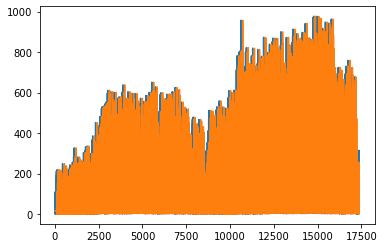

In [52]:
bike_all_lag['count'].plot()
bike_all_lag['count_lag100'].plot()

## 2. Error analysis

In [53]:
def error_analysis(Y_Data, Target_name, X_Data, graph_on=False):
    for x in Target_name:
        Target_name = x
    X_Data = X_Data.loc[Y_Data.index]

    if graph_on == True:
        ##### Error Analysis(Plot)
        Y_Data['RowNum'] = Y_Data.reset_index().index

        # Stationarity(Trend) Analysis
        sns.set(palette="muted", color_codes=True, font_scale=2)
        sns.lmplot(x='RowNum', y=Target_name, data=Y_Data,
                   fit_reg='True', size=5.2, aspect=2, ci=99, sharey=True)
        del Y_Data['RowNum']

        # Normal Distribution Analysis
        figure, axes = plt.subplots(figsize=(12, 8))
        sns.distplot(Y_Data[Target_name], norm_hist='True',
                     fit=stats.norm, ax=axes)

        # Lag Analysis
        length = int(len(Y_Data[Target_name])/10)
        figure, axes = plt.subplots(1, 4, figsize=(12, 3))
        pd.plotting.lag_plot(Y_Data[Target_name], lag=1, ax=axes[0])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=5, ax=axes[1])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=10, ax=axes[2])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=50, ax=axes[3])

        # Autocorrelation Analysis
        figure, axes = plt.subplots(2, 1, figsize=(12, 5))
        sm.tsa.graphics.plot_acf(
            Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[0])
        sm.tsa.graphics.plot_pacf(
            Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[1])



## 3. Helper functions for future examples

In [54]:
### Feature engineering of default
def non_feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])
    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)
    # bring back
    # if raw.index.dtype != 'int64':
    #     raw.reset_index(drop=False, inplace=True)
    raw = raw.asfreq('H', method='ffill')
    raw_nfe = raw.copy()
    return raw_nfe
# raw_rd = non_feature_engineering(bitcoin_all)


### Feature engineering of all
def feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])

    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)

    raw = raw.asfreq('H', method='ffill')

    result = sm.tsa.seasonal_decompose(raw['count'], model='additive')
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['count_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['count_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    if 'count_trend' not in raw.columns:
        if 'count_seasonal' not in raw.columns:
            raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)

    Y_count_Day = raw[['count']].rolling(24).mean()
    Y_count_Day.fillna(method='ffill', inplace=True)
    Y_count_Day.fillna(method='bfill', inplace=True)
    Y_count_Day.columns = ['count_Day']
    Y_count_Week = raw[['count']].rolling(24*7).mean()
    Y_count_Week.fillna(method='ffill', inplace=True)
    Y_count_Week.fillna(method='bfill', inplace=True)
    Y_count_Week.columns = ['count_Week']
    if 'count_Day' not in raw.columns:
        raw = pd.concat([raw, Y_count_Day], axis=1)
    if 'count_Week' not in raw.columns:
        raw = pd.concat([raw, Y_count_Week], axis=1)

    Y_diff = raw[['count']].diff()
    Y_diff.fillna(method='ffill', inplace=True)
    Y_diff.fillna(method='bfill', inplace=True)
    Y_diff.columns = ['count_diff']
    if 'count_diff' not in raw.columns:
        raw = pd.concat([raw, Y_diff], axis=1)

    raw['temp_group'] = pd.cut(raw['temp'], 10)
    raw['Year'] = raw.datetime.dt.year
    raw['Quarter'] = raw.datetime.dt.quarter
    raw['Quarter_ver2'] = raw['Quarter'] + (raw.Year - raw.Year.min()) * 4
    raw['Month'] = raw.datetime.dt.month
    raw['Day'] = raw.datetime.dt.day
    raw['Hour'] = raw.datetime.dt.hour
    raw['DayofWeek'] = raw.datetime.dt.dayofweek

    raw['count_lag1'] = raw['count'].shift(1)
    raw['count_lag2'] = raw['count'].shift(2)
    raw['count_lag1'].fillna(method='bfill', inplace=True)
    raw['count_lag2'].fillna(method='bfill', inplace=True)

    if 'Quarter' in raw.columns:
        if 'Quarter_Dummy' not in ['_'.join(col.split('_')[:2]) for col in raw.columns]:
            raw = pd.concat([raw, pd.get_dummies(raw['Quarter'], 
                                                 prefix='Quarter_Dummy', drop_first=True)], axis=1)
            del raw['Quarter']
    raw_fe = raw.copy()
    return raw_fe
# raw_fe = feature_engineering(bitcoin_all)


### Data split of cross sectional
def datasplit_cs(raw, Y_colname, X_colname, test_size, random_seed=123):
    X_train, X_test, Y_train, Y_test = train_test_split(raw[X_colname], raw[Y_colname], test_size=test_size, random_state=random_seed)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_cs(raw_fe, Y_colname, X_colname, 0.2)


### Data split of time series
def datasplit_ts(raw, Y_colname, X_colname, criteria):
    raw_train = raw.loc[raw.index < criteria,:]
    raw_test = raw.loc[raw.index >= criteria,:]
    Y_train = raw_train[Y_colname]
    X_train = raw_train[X_colname]
    Y_test = raw_test[Y_colname]
    X_test = raw_test[X_colname]
    print('Train_size:', raw_train.shape, 'Test_size:', raw_test.shape)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_ts(raw_fe, Y_colname, X_colname, '2012-07-01')


### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual
# Score_tr, Residual_tr = evaluation(Y_train, pred_tr_reg1, graph_on=True)


### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te
# Score_reg1, Resid_tr_reg1, Resid_te_reg1 = evaluation_trte(Y_train, pred_tr_reg1, Y_test, pred_te_reg1, graph_on=True)


### Error analysis
def stationarity_adt_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_adt = pd.Series(sm.tsa.stattools.adtuller(Y_Data)[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adtuller(Y_Data)[4].items():
            Stationarity_adt['Critical Value(%s)'%key] = value
            Stationarity_adt['Maximum Information Criteria'] = sm.tsa.stattools.adtuller(Y_Data)[5]
            Stationarity_adt = pd.DataFrame(Stationarity_adt, columns=['Stationarity_adt'])
    else:
        Stationarity_adt = pd.Series(sm.tsa.stattools.adtuller(Y_Data[Target_name])[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adtuller(Y_Data[Target_name])[4].items():
            Stationarity_adt['Critical Value(%s)'%key] = value
            Stationarity_adt['Maximum Information Criteria'] = sm.tsa.stattools.adtuller(Y_Data[Target_name])[5]
            Stationarity_adt = pd.DataFrame(Stationarity_adt, columns=['Stationarity_adt'])
    return Stationarity_adt

def stationarity_kpss_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data)[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data)[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    else:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data[Target_name])[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data[Target_name])[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    return Stationarity_kpss

def error_analysis(Y_Data, Target_name, X_Data, graph_on=False):
    for x in Target_name:
        Target_name = x
    X_Data = X_Data.loc[Y_Data.index]

    if graph_on == True:
        ##### Error Analysis(Plot)
        Y_Data['RowNum'] = Y_Data.reset_index().index

        # Stationarity(Trend) Analysis
        sns.set(palette="muted", color_codes=True, font_scale=2)
        sns.lmplot(x='RowNum', y=Target_name, data=Y_Data, fit_reg='True', size=5.2, aspect=2, ci=99, sharey=True)
        del Y_Data['RowNum']

        # Normal Distribution Analysis
        figure, axes = plt.subplots(figsize=(12,8))
        sns.distplot(Y_Data[Target_name], norm_hist='True', fit=stats.norm, ax=axes)

        # Lag Analysis
        length = int(len(Y_Data[Target_name])/10)
        figure, axes = plt.subplots(1, 4, figsize=(12,3))
        pd.plotting.lag_plot(Y_Data[Target_name], lag=1, ax=axes[0])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=5, ax=axes[1])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=10, ax=axes[2])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=50, ax=axes[3])

        # Autocorrelation Analysis
        figure, axes = plt.subplots(2,1,figsize=(12,5))
        sm.tsa.graphics.plot_acf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[0])
        sm.tsa.graphics.plot_pacf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[1])

    ##### Error Analysis(Statistics)
    # Checking Stationarity
    # Null Hypothesis: The Time-series is non-stationalry
    Stationarity_adt = stationarity_adt_test(Y_Data, Target_name)
    Stationarity_kpss = stationarity_kpss_test(Y_Data, Target_name)

    # Checking of Normality
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Y_Data[Target_name])],
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    # Checking for Autocorrelation
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[0], columns=['Test Statistics']),
                                 pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[1], columns=['p-value'])], axis=1).T
    Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']

    # Checking Heteroscedasticity
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldteldquandt(Y_Data[Target_name], X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], columns=['Test Statistics', 'p-value', 'Alternative']).T
    Score = pd.concat([Stationarity_adt, Stationarity_kpss, Normality, Autocorrelation, Heteroscedasticity], join='outer', axis=1)
    index_new = ['Test Statistics', 'p-value', 'Alternative', 'Used Lag', 'Used Observations',
                 'Critical Value(1%)', 'Critical Value(5%)', 'Critical Value(10%)', 'Maximum Information Criteria']
    Score.reindex(index_new)
    return Score
# error_analysis(Resid_tr_reg1[1:], ['Error'], X_train, graph_on=True)

### Load DNN modules

In [55]:
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import SimpleRNN, LSTM, GRU

## Example 1: Bitcoin Prediction
### MLP

Train_size: (1095, 1) Test_size: (305, 1)
X_train: (1035, 60, 1) Y_train: (1035, 1)
X_test: (245, 60, 1) Y_test: (245, 1)
Reshaping for MLP
X_train: (1035, 60) Y_train: (1035, 1)
X_test: (245, 60) Y_test: (245, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               7808      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                        

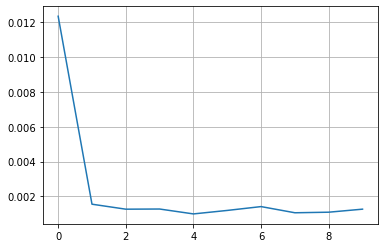

8/8 [==============================] - 0s 1000us/step - loss: 9.0268e-16


,MAE,MSE,MAPE
Train,472.39,"408,616.59",7.51
Test,437.85,"359,852.64",5.31


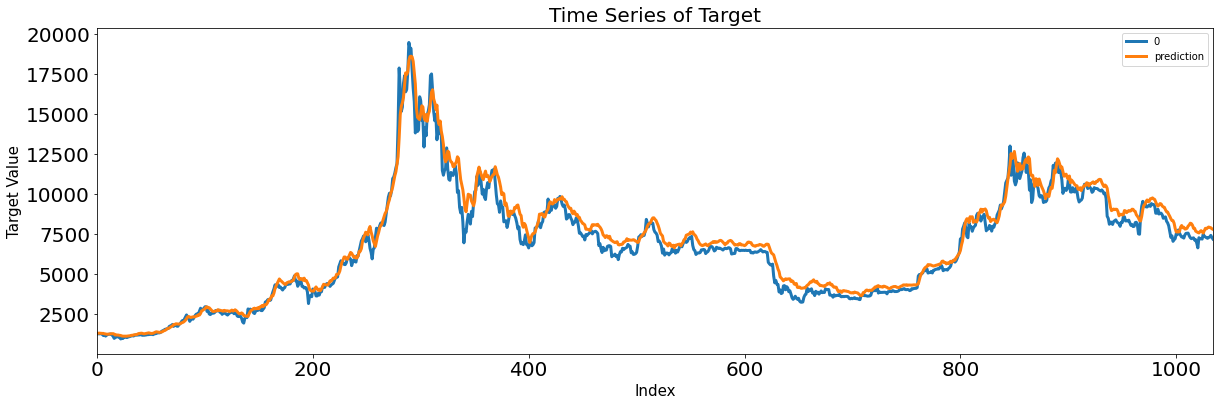

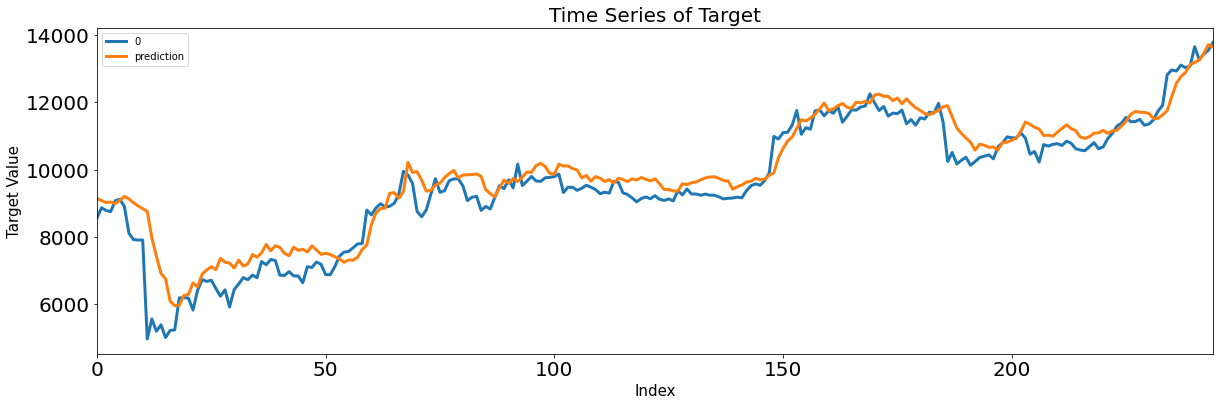

In [57]:
# Data Loading
bitcoin_all = pd.read_csv(bitcoin_location, index_col='Date')
bitcoin_all.index = pd.to_datetime(bitcoin_all.index)

# Parameters
criteria = '2020-01-01'
scaler = preprocessing.MinMaxScaler()
sequence = 60
batch_size = 32
epoch = 10
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Train & Test Split
train = bitcoin_all.loc[bitcoin_all.index < criteria, :]
test = bitcoin_all.loc[bitcoin_all.index >= criteria, :]
print('Train_size:', train.shape, 'Test_size:', test.shape)

## Scaling
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(train_scaled) - sequence):
    X_train.append(train_scaled[index: index + sequence])
    Y_train.append(train_scaled[index + sequence])
X_test, Y_test = [], []
for index in range(len(test_scaled) - sequence):
    X_test.append(test_scaled[index: index + sequence])
    Y_test.append(test_scaled[index + sequence])

## Retype and Reshape
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# MLP
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
print('Reshaping for MLP')
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train,
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler != []:
    Y_train = scaler.inverse_transform(Y_train)
    Y_train_pred = scaler.inverse_transform(Y_train_pred)
    Y_test = scaler.inverse_transform(Y_test)
    Y_test_pred = scaler.inverse_transform(Y_test_pred)
Score_MLP, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(),
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_MLP)


### RNN

Train_size: (1095, 1) Test_size: (305, 1)
X_train: (1035, 60, 1) Y_train: (1035, 1)
X_test: (245, 60, 1) Y_test: (245, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 60, 128)           16640     
                                                                 
 dropout_4 (Dropout)         (None, 60, 128)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 60, 256)           98560     
                                                                 
 dropout_5 (Dropout)         (None, 60, 256)           0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 60, 128)           49280     
                                                                 
 dropout_6 (Dropout)         (None, 60, 128)           0        

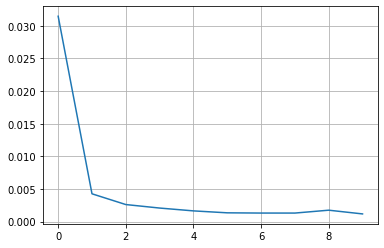

8/8 [==============================] - 0s 15ms/step - loss: 3.4612e-15


,MAE,MSE,MAPE
Train,636.26,"815,567.09",10.35
Test,"1,042.29","1,322,010.28",10.68


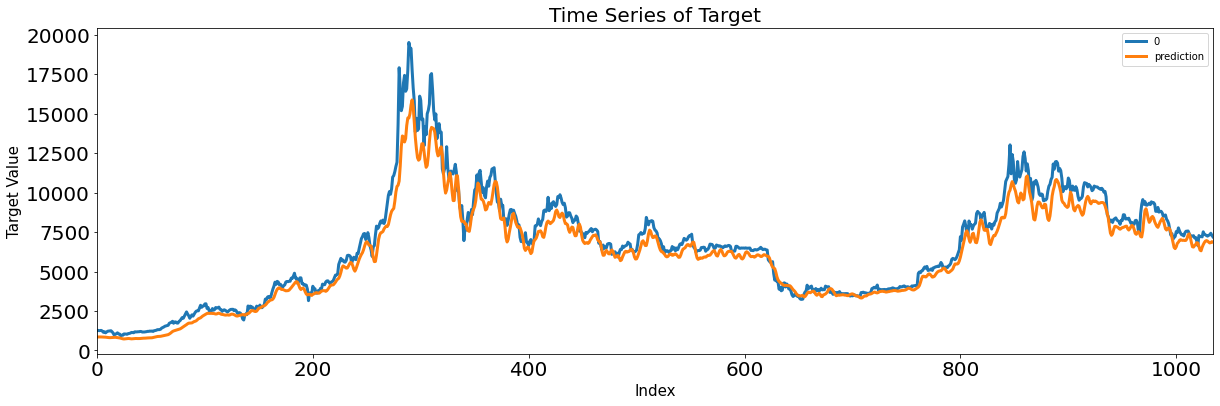

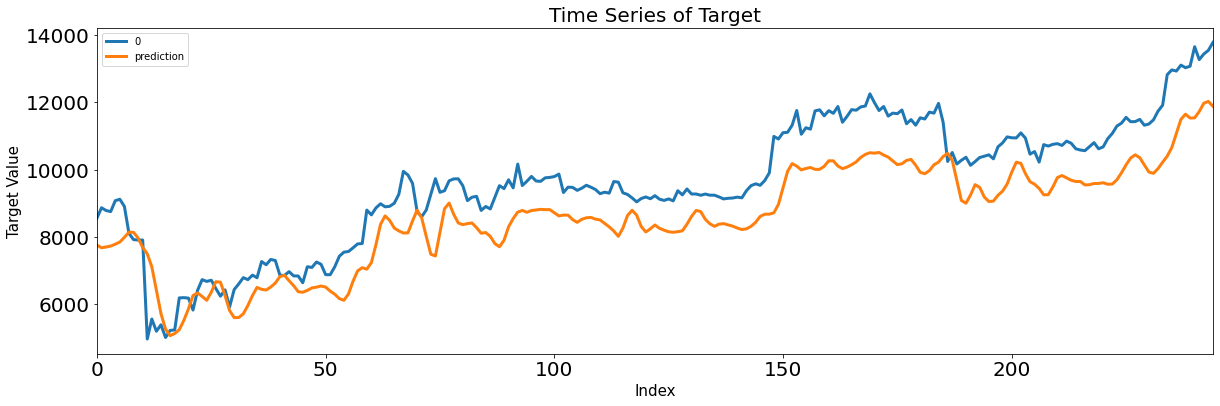

In [58]:

bitcoin_all = pd.read_csv(bitcoin_location, index_col='Date')
bitcoin_all.index = pd.to_datetime(bitcoin_all.index)

# Parameters
criteria = '2020-01-01'
scaler = preprocessing.MinMaxScaler()
sequence = 60
batch_size = 32
epoch = 10
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Train & Test Split
train = bitcoin_all.loc[bitcoin_all.index < criteria, :]
test = bitcoin_all.loc[bitcoin_all.index >= criteria, :]
print('Train_size:', train.shape, 'Test_size:', test.shape)

## Scaling
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(train_scaled) - sequence):
    X_train.append(train_scaled[index: index + sequence])
    Y_train.append(train_scaled[index + sequence])
X_test, Y_test = [], []
for index in range(len(test_scaled) - sequence):
    X_test.append(test_scaled[index: index + sequence])
    Y_test.append(test_scaled[index + sequence])

## Retype and Reshape
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# RNN
model = Sequential()
model.add(SimpleRNN(128, input_shape=(
    X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(SimpleRNN(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio))
model.add(SimpleRNN(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio))
model.add(SimpleRNN(64, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train,
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler != []:
    Y_train = scaler.inverse_transform(Y_train)
    Y_train_pred = scaler.inverse_transform(Y_train_pred)
    Y_test = scaler.inverse_transform(Y_test)
    Y_test_pred = scaler.inverse_transform(Y_test_pred)
Score_RNN, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(),
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_RNN)


### LSTM

In [ ]:
bitcoin_all = pd.read_csv(bitcoin_location, index_col='Date')
bitcoin_all.index = pd.to_datetime(bitcoin_all.index)

# Parameters
criteria = '2020-01-01'
scaler = preprocessing.MinMaxScaler()
sequence = 60
batch_size = 32
epoch = 10
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Train & Test Split
train = bitcoin_all.loc[bitcoin_all.index < criteria, :]
test = bitcoin_all.loc[bitcoin_all.index >= criteria, :]
print('Train_size:', train.shape, 'Test_size:', test.shape)

## Scaling
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(train_scaled) - sequence):
    X_train.append(train_scaled[index: index + sequence])
    Y_train.append(train_scaled[index + sequence])
X_test, Y_test = [], []
for index in range(len(test_scaled) - sequence):
    X_test.append(test_scaled[index: index + sequence])
    Y_test.append(test_scaled[index + sequence])

## Retype and Reshape
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(
    X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(LSTM(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio))
model.add(LSTM(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio))
model.add(LSTM(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train,
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler != []:
    Y_train = scaler.inverse_transform(Y_train)
    Y_train_pred = scaler.inverse_transform(Y_train_pred)
    Y_test = scaler.inverse_transform(Y_test)
    Y_test_pred = scaler.inverse_transform(Y_test_pred)
Score_LSTM, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(),
                                                       pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_LSTM)


### GRU

bitcoin_all = pd.read_csv(bitcoin_location, index_col='Date')
bitcoin_all.index = pd.to_datetime(bitcoin_all.index)

# Parameters
criteria = '2020-01-01'
scaler = preprocessing.MinMaxScaler()
sequence = 60
batch_size = 32
epoch = 10
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Train & Test Split
train = bitcoin_all.loc[bitcoin_all.index < criteria,:]
test = bitcoin_all.loc[bitcoin_all.index >= criteria,:]
print('Train_size:', train.shape, 'Test_size:', test.shape)

## Scaling
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(train_scaled) - sequence):
    X_train.append(train_scaled[index: index + sequence])
    Y_train.append(train_scaled[index + sequence])
X_test, Y_test = [], []
for index in range(len(test_scaled) - sequence):
    X_test.append(test_scaled[index: index + sequence])
    Y_test.append(test_scaled[index + sequence])

## Retype and Reshape
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# GRU
model = Sequential()
model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler != []:
    Y_train = scaler.inverse_transform(Y_train)
    Y_train_pred = scaler.inverse_transform(Y_train_pred)
    Y_test = scaler.inverse_transform(Y_test)
    Y_test_pred = scaler.inverse_transform(Y_test_pred)
Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_GRU)
